<a href="https://colab.research.google.com/github/karthiklakkur1/Crop-weed-extension/blob/main/medicinalplantdataset_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishnuoum/medicinal-plant-dataset-augmented")

print("Path to dataset files:", path)

100%|██████████| 1.31G/1.31G [00:18<00:00, 74.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vishnuoum/medicinal-plant-dataset-augmented/versions/1


In [2]:
import shutil

# Source: dataset path from kagglehub
src_path = "/root/.cache/kagglehub/datasets/vishnuoum/medicinal-plant-dataset-augmented/versions/1"

# Destination: your desired folder in Google Drive
dst_path = "/content/drive/MyDrive/medicinal-plant-dataset"

# Copy the dataset recursively
shutil.copytree(src_path, dst_path)


'/content/drive/MyDrive/medicinal-plant-dataset'

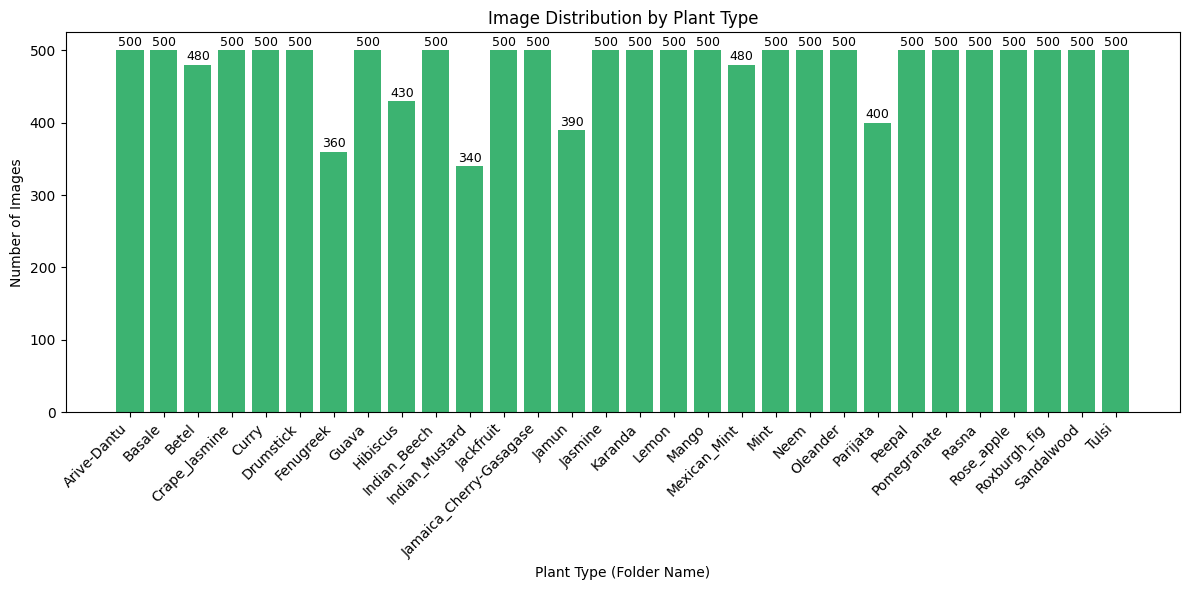

In [3]:
import os
import matplotlib.pyplot as plt

# Path to your dataset folders inside Google Drive
dataset_path = '/content/drive/MyDrive/medicinal-plant-dataset/data'

# Get folder names and image counts
class_names = []
image_counts = []

for folder_name in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_names.append(folder_name)
        image_counts.append(num_images)

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, image_counts, color='mediumseagreen')
plt.xlabel('Plant Type (Folder Name)')
plt.ylabel('Number of Images')
plt.title('Image Distribution by Plant Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, str(height), ha='center', va='bottom', fontsize=9)

plt.show()
